# Get Feet Trajctories Dict 

File is loaded successfully.


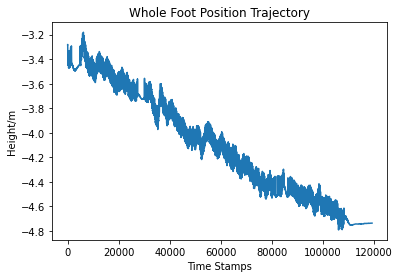

In [6]:
# Download example FeetTrajs file at https://drive.google.com/file/d/170SH3jFDTfLugwh51p7GoAUx6M0LO9uZ/view?usp=sharing
# Download example Ground file at https://drive.google.com/file/d/1r_JcgYux0izmfm8O_iw-8k40j92zeZc6/view?usp=sharing
import msgpack
import matplotlib.pyplot as plt
import numpy as np

with open ('/home/anqiao/catkin_ws/SA_dataset/20211007_SA_Monkey_ANYmal_Chimera/chimera_mission_2021_10_08/mission3/test/Reconstruct_2022-03-26-10-41-08_0/FeetTrajs.msgpack' , 'rb') as data_file:
    data = data_file.read()
    data = msgpack.unpackb(data)
    print("File is loaded successfully.")
    
FeetTrajs = {}
for key, value in data.items():
    FeetTrajs[key] = np.array(value)
plt.plot(FeetTrajs['LF_shank_fixed_LF_FOOT'][:, 2])
plt.title("Whole Foot Position Trajectory")
plt.xlabel("Timestamp")
plt.ylabel("Height/m")
plt.show()

# Get Contact Points

In [10]:
def getContactPoints(FootTrajSlice):
# FootTrajSlice = FeetTrajs['LF_shank_fixed_LF_FOOT']
    ContactShow  = []
    ContactPoints = []
    BIGWINDOW = 500
    SMALLWINDOW = 40
    SMALLWINDOWED = 0.015
    # Calculate the mean of the big window
    for bigWindowCount in range(len(FootTrajSlice)//BIGWINDOW+1):
        bWFront = bigWindowCount*BIGWINDOW
        bWBack = bWFront+BIGWINDOW
        if bWBack < len(FootTrajSlice) -1:
            bWBack = bWBack
            ref = (FootTrajSlice[bWFront:bWBack, 2]).mean()
        else:
            # Do not update ref since the ref is not accurate
            bWBack = len(FootTrajSlice) -1
        # print("Processing the "+str(bigWindowCount)+"th BigWindow")

        # Calculate the extrame deviation(ED) of the small window
        for smallWindowCount in range(bWBack - bWFront+1):
            sWFront = bWFront + smallWindowCount
            sWBack = sWFront + SMALLWINDOW
            if sWBack < len(FootTrajSlice) -1:
                sWBack = sWBack     
            else:
                # abondan last small window, since the ED is not accurate
                break
            smallWindowData = FootTrajSlice[sWFront:sWBack, 2]
            # print(sWFront, sWBack)
            if abs(smallWindowData.max() - smallWindowData.min()) < SMALLWINDOWED and smallWindowData.min()<ref:
                ContactShow.append(FootTrajSlice[sWFront, 2])
                ContactPoints.append(FootTrajSlice[sWFront])
                # ContactPoints.append(FootTrajSlice[sWFront+ SMALLWINDOW//2])
            else:
                ContactShow.append(None)
    
    return ContactPoints, ContactShow



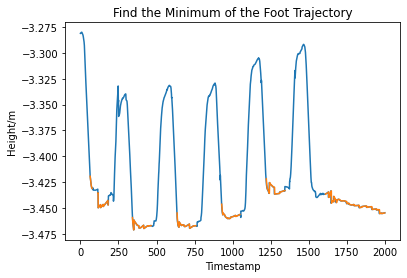

In [11]:
# Visualize the effect on a short trajectory
# Since we only use local information, the method is not valid when the data is not fluctuate for a much longer time then the scale of the big window.
_, ContactShow = getContactPoints(FeetTrajs["LF_shank_fixed_LF_FOOT"])
plt.plot(FeetTrajs["LF_shank_fixed_LF_FOOT"][0:2000, 2])
plt.plot(ContactShow[0:2000])
plt.xlabel("Timestamp")
plt.ylabel("Height/m")
plt.title("Find the Minimum of the Foot Trajectory")
plt.show()


In [12]:
# Get contact points for all feet trajectories
ContactPoints = []
for value in FeetTrajs.values():
    newPoints, _ = getContactPoints(value)
    ContactPoints = ContactPoints + newPoints

print(len(ContactPoints))


211450


# Construct Ground Sparse Map

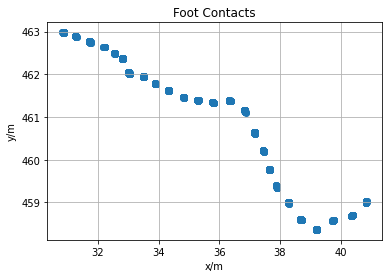

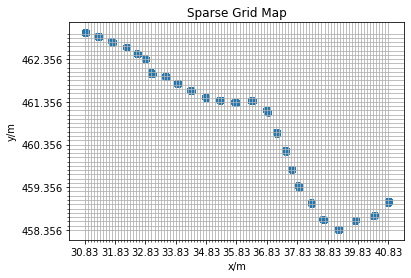

In [21]:
# Check the Contact Points we already have
ContactArray = np.array(ContactPoints)
ContactArraySlice = ContactArray[0:5000]
plt.scatter(ContactArraySlice[:, 0], ContactArraySlice[:, 1])
plt.title("Foot Contacts")
plt.xlabel("x/m")
plt.ylabel("y/m")
plt.grid()
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(ContactArraySlice[:, 0], ContactArraySlice[:, 1])

major_ticks = np.arange(min(ContactArraySlice[:, 0]), max(ContactArraySlice[:, 0]), 1)
minor_ticks = np.arange(min(ContactArraySlice[:, 0]), max(ContactArraySlice[:, 0]), 0.1)

ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)

major_ticks = np.arange(min(ContactArraySlice[:, 1]), max(ContactArraySlice[:, 1]), 1)
minor_ticks = np.arange(min(ContactArraySlice[:, 1]), max(ContactArraySlice[:, 1]), 0.1)

ax.set_yticks(major_ticks)
ax.set_yticks(minor_ticks, minor=True)

# And a corresponding grid
ax.grid(which='both')

# Or if you want different settings for the grids:
# ax.grid(which='minor', alpha=2)
# ax.grid(which='major', alpha=0.5)
plt.title("Sparse Grid Map")
plt.xlabel("x/m")
plt.ylabel("y/m")

plt.show()


In [22]:
# Get sparse grid map
from scipy.sparse import bsr_array
from numpy import asarray as ar
import math


def intArray(array):
    """Convert an numpy array or a number to int"""
    if(type(array) != np.ndarray):
        return int(array)
    else:
        intarray = np.empty(shape=array.size, dtype=int)
        for i, num in enumerate(array):
            intarray[i] = int(num)
        return intarray

res = 0.1
xlength = math.ceil((ContactArray[:, 0].max() - ContactArray[:, 0].min())/res)
ylength = math.ceil((ContactArray[:, 1].max() - ContactArray[:, 1].min())/res)
xNormal = int(ContactArray[:, 0].min()/res)
yNormal = int(ContactArray[:, 1].min()/res)

x = intArray(ContactArray[:, 0]/res) - xNormal
y = intArray(ContactArray[:, 1]/res) - yNormal
z = ContactArray[:, 2]

IntArray = np.stack([x, y, z])

CountContactArray = np.zeros(shape=(xlength, ylength))
GroundArray2 = np.zeros(shape=(xlength, ylength))
for i in range(x.size):
    CountContactArray[x[i]][y[i]] = CountContactArray[x[i]][y[i]]+1
    GroundArray2[x[i]][y[i]] = GroundArray2[x[i]][y[i]] + z[i]
GroundArray2 = np.true_divide(GroundArray2, CountContactArray)

GroundArray2 = np.nan_to_num(GroundArray2)

/tmp/ipykernel_203715/226580278.py:34: RuntimeWarning: invalid value encountered in true_divide
  GroundArray2 = np.true_divide(GroundArray2, CountContactArray)


In [23]:
# Test the grid map
def getGroundHeight(x, y):
    array = GroundArray2
    return array[intArray(x/res) - xNormal, intArray(y/res)-yNormal]

x = np.array([30.842474971923533, 30.842474971923533])
y = np.array([462.984496350972, 462.984496350972])
print(getGroundHeight(x,y))
     

[-3.4431972 -3.4431972]


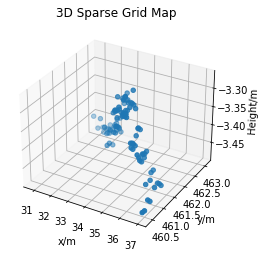

In [25]:
# Visualize the sparse grid map
range = np.arange(1, 100)
nonzero = np.where(GroundArray2[:, :]!=0)
x_nonzero = nonzero[0][range]
x_nonzeroReal = (x_nonzero+xNormal)*res

y_nonzero = nonzero[1][range]
y_nonzeroReal = (y_nonzero+yNormal)*res
z_nonzero = GroundArray2[x_nonzero, y_nonzero]
# z_nonzero = getGroundHeight(x_nonzero, y_nonzero)

ax = plt.axes(projection='3d')
plt.xlabel("x/m")
plt.ylabel("y/m")
ax.set_zlabel("Height/m")
ax.set_title("3D Sparse Grid Map")
ax.scatter3D(x_nonzeroReal, y_nonzeroReal, z_nonzero)

# Enhance Map 

In [26]:
# Check the non-zero element in sparse map 
nonzero = np.where(GroundArray2[:, :]!=0)
x_nonzero = nonzero[0]
y_nonzero = nonzero[1]
z_nonzero = GroundArray2[x_nonzero, y_nonzero]
len(z_nonzero)

2500

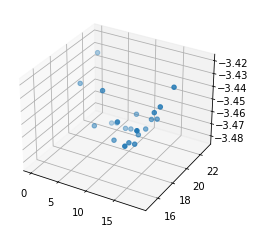

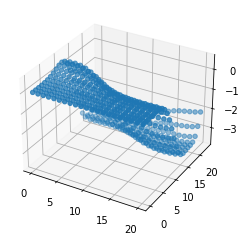

[[-3.4431972]]


In [20]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

def visualizeArray(Larray):
    nonzero = np.where(Larray[:, :]!=0)

    ax = plt.axes(projection='3d')
    ax.scatter3D(nonzero[0], nonzero[1], Larray[nonzero[0], nonzero[1]])
    plt.show()

def getGPHeight(x, y, step = 20, visualize=True):
    # radius = step*res = 2
    array = GroundArray2
    xGround = intArray(x/res) - xNormal
    yGround = intArray(y/res)-yNormal

    # xLocalArray = np.arange(max(xGround-10, 0), min(xGround+10, xlength))
    # yLocalArray = np.arange(max(yGround-10, 0), min(yGround+10, ylength))
    
    LocalArray = GroundArray2[max(xGround-step, 0): min(xGround+step, xlength),\
                            max(yGround-step, 0): min(yGround+step, ylength)]
    nonzero = np.where(LocalArray[:, :]!=0)

    
    if visualize == True:
        visualizeArray(LocalArray)

    trainX = np.stack([nonzero[0], nonzero[1]]).T
    trainY = (LocalArray[nonzero[0], nonzero[1]]).reshape(-1, 1)

    kernel = C(1.0, (1e-3, 1e3)) * RBF([5,5], (1e-2, 1e2))
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=15)
    gp.fit(trainX, trainY)

    
    y_pred, MSE = gp.predict(np.array([min(step, xGround), min(step, yGround)]).reshape(1, -1), return_std=True)
    # print(y_pred, MSE)
    if(visualize):
        xTest = np.arange(0, LocalArray.shape[0], 1)
        yTest = np.arange(0, LocalArray.shape[1], 1)
        # testX = np.stack([xTest, yTest])

        xx, yy = np.meshgrid(xTest, yTest)
        xx = xx.flatten()
        yy = yy.flatten()
        testX = np.stack([xx, yy])
        testY, MSET = gp.predict(testX.T, return_std=True)
        zz = testY.T

        ax = plt.axes(projection='3d')
        ax.scatter3D(xx, yy, zz)
        plt.show()
    return y_pred[0], MSE[0]

# Test the function
# x = np.array([30.842474971923533, 30.842474971923533])
# y = np.array([462.984496350972, 462.984496350972])
x = 30.842474971923533
y = 462.984496350972
print(getGPHeight(x,y))

# Complete Class

/home/anqiao/.local/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


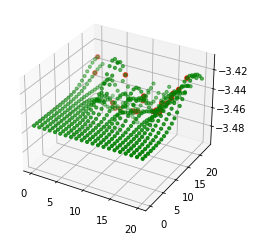

(array([-3.4431972]), 0.999900005007947)


In [3]:
from cProfile import label
from turtle import color
from cv2 import mean
import msgpack
import matplotlib.pyplot as plt
import numpy as np
import math
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from numpy import asarray as ar, ndarray

# Class GFT provides utility functions to work with ground map extracted from feet trajctories. 
# The class can be instantiated by feet trajectory file (saved by extractFeetTrajsFromRosbag.py in pyenv)
# or by file saved by the calss itself. The main method is getHeight(self, x, y, method = 'sparse'), 
# given the target point, it will return the height of that point.

class GFT:
    """This class provides utility functions to work with 
    ground map extracted from feet trajctories."""
    FeetTrajs = {}
    ContactArray = np.empty(shape=0)
    GroundArray = np.empty(shape=0)

    xlength = 0
    ylength = 0
    xNormal = 0
    yNormal = 0

    xRealRange = (0, 0)
    yRealRange = (0, 0)
    res = 0
    meanHeight = 0

    def __init__(self, GroundMapFile=None, FeetTrajsFile=None) -> None:

        assert (GroundMapFile!=None and FeetTrajsFile==None) or (GroundMapFile==None and FeetTrajsFile!=None), \
            f"One and only one file should be provided"

        # Get GroundArray from saved GFT msgpack
        if GroundMapFile != None:
            self.GroundArray = self.load(GroundMapFile)
        else:
        # Get GroundArray from saved Feet Trajectories
            self.ContactArray, self.FeetTrajs = self.getContactPointsFromFile(
                FeetTrajsFile)
            self.GroundArray = self.getGroundFromContact(self.ContactArray)

    def getContactPointsFromFile(self, FeetTrajsFile):
        """Get contact points from four feet Trajectories"""
        with open(FeetTrajsFile, 'rb') as data_file:
            data = data_file.read()
            data = msgpack.unpackb(data)
            print("File is loaded successfully.")

        FeetTrajs = {}
        for key, value in data.items():
            FeetTrajs[key] = np.array(value)

        ContactPoints = []
        for value in FeetTrajs.values():
            newPoints, _ = self.getContactPoints(value)
            ContactPoints = ContactPoints + newPoints

        return np.array(ContactPoints), FeetTrajs

    def getContactPoints(self, FootTrajSlice):
        """Get contact points from one foot's Trajectories. Construct big window and small window.
        Use the mean of the big window and extrame deviation to filter the points"""
        print("Extracting Contact points ......")
    # FootTrajSlice = FeetTrajs['LF_shank_fixed_LF_FOOT']
        ContactShow = []
        ContactPoints = []
        BIGWINDOW = 500
        SMALLWINDOW = 40
        SMALLWINDOWED = 0.015
        # Calculate the mean of the big window
        for bigWindowCount in range(len(FootTrajSlice)//BIGWINDOW+1):
            bWFront = bigWindowCount*BIGWINDOW
            bWBack = bWFront+BIGWINDOW
            if bWBack < len(FootTrajSlice) - 1:
                bWBack = bWBack
                ref = (FootTrajSlice[bWFront:bWBack, 2]).mean()
            else:
                # Do not update ref since the ref is not accurate
                bWBack = len(FootTrajSlice) - 1
            # print("Processing the "+str(bigWindowCount)+"th BigWindow")

            # Calculate the extrame deviation(ED) of the small window
            for smallWindowCount in range(bWBack - bWFront+1):
                sWFront = bWFront + smallWindowCount
                sWBack = sWFront + SMALLWINDOW
                if sWBack < len(FootTrajSlice) - 1:
                    sWBack = sWBack
                else:
                    # abondan last small window, since the ED is not accurate
                    break
                smallWindowData = FootTrajSlice[sWFront:sWBack, 2]
                # print(sWFront, sWBack)
                if abs(smallWindowData.max() - smallWindowData.min()) < SMALLWINDOWED and smallWindowData.min() < ref:
                    ContactShow.append(FootTrajSlice[sWFront, 2])
                    ContactPoints.append(FootTrajSlice[sWFront])
                    # ContactPoints.append(FootTrajSlice[sWFront+ SMALLWINDOW//2])
                else:
                    ContactShow.append(None)

        return ContactPoints, ContactShow

    def intArray(self, array):
        """Convert an numpy array or a number to int"""
        if(type(array) != np.ndarray):
            return int(array)
        else:
            intarray = np.empty(shape=array.size, dtype=int)
            for i, num in enumerate(array):
                intarray[i] = int(num)
            return intarray

    def getGroundFromContact(self, ContactArray):
        """Get grid map of ground from Contact points. For each grid, calculate the mean of the contacts height. """
        self.res = 0.1
        self.xRealRange = (ContactArray[:, 0].min(), ContactArray[:, 0].max())
        self.yRealRange = (ContactArray[:, 1].min(), ContactArray[:, 1].max())
        self.xlength = math.ceil(
            (ContactArray[:, 0].max() - ContactArray[:, 0].min())/self.res)
        self.ylength = math.ceil(
            (ContactArray[:, 1].max() - ContactArray[:, 1].min())/self.res)
        self.xNormal = int(ContactArray[:, 0].min()/self.res)
        self.yNormal = int(ContactArray[:, 1].min()/self.res)

        x = self.intArray(ContactArray[:, 0]/self.res) - self.xNormal
        y = self.intArray(ContactArray[:, 1]/self.res) - self.yNormal
        z = ContactArray[:, 2]

        CountContactArray = np.zeros(shape=(self.xlength, self.ylength))
        GroundArray = np.zeros(shape=(self.xlength, self.ylength))
        for i in range(x.size):
            CountContactArray[x[i], y[i]] = CountContactArray[x[i], y[i]]+1
            GroundArray[x[i], y[i]] = GroundArray[x[i], y[i]] + z[i]
        GroundArray = np.true_divide(GroundArray, CountContactArray)

        GroundArray = np.nan_to_num(GroundArray)
        nonZero = np.where(GroundArray[:,:]!=0)
        self.meanHeight = (GroundArray[nonZero[0], nonZero[1]]).mean()

        return GroundArray
        

    def getMean(self, Array):
        return self.mean
    def save(self, out_dir):
        save_dict = {}
        save_dict["res"] = self.res
        save_dict["xNormal"] = self.xNormal
        save_dict["yNormal"] = self.yNormal
        save_dict["xRealRange"] = self.xRealRange
        save_dict["yRealRange"] = self.yRealRange
        save_dict["GroundArray"] = self.GroundArray.tolist()
        save_dict["meanHeight"] = self.meanHeight
        save_path = out_dir + "/GroundMap.msgpack"
        with open(save_path, "wb") as out_file:
            out_data = msgpack.packb(save_dict)
            out_file.write(out_data)

    def load(self, ground_dir):
        with open(ground_dir, "rb") as data_file:
            data = data_file.read()
            ground_dict = msgpack.unpackb(data)
        self.res = ground_dict["res"]
        self.xNormal = ground_dict["xNormal"]
        self.yNormal = ground_dict["yNormal"]
        self.GroundArray = np.array(ground_dict["GroundArray"])
        self.xlength = self.GroundArray.shape[0]
        self.ylength = self.GroundArray.shape[1]
        self.xRealRange = ground_dict["xRealRange"]
        self.yRealRange = ground_dict["yRealRange"]
        self.meanHeight = ground_dict["meanHeight"]

        return self.GroundArray

    def visualizeContacts3D(self, range = None):
        """Visualize sparse grid map"""
        assert range is None or (range[-1]<self.xlength and range[-1]<self.ylength),\
            f"Range exceed the size of the map, the grid map size is {self.xlength} * {self.ylength}"
        nonzero = np.where(self.GroundArray[:, :]!=0)
        x_nonzero = nonzero[0][range]
        x_nonzeroReal = (x_nonzero+self.xNormal)*self.res

        y_nonzero = nonzero[1][range]
        y_nonzeroReal = (y_nonzero+self.yNormal)*self.res

        z_nonzero = self.GroundArray[x_nonzero, y_nonzero]
        # z_nonzero = getGroundHeight(x_nonzero, y_nonzero)

        ax = plt.axes(projection='3d')
        plt.xlabel("x/m")
        plt.ylabel("y/m")
        ax.set_zlabel("Height/m")

        ax.scatter3D(x_nonzeroReal, y_nonzeroReal, z_nonzero)

        plt.show()

    def visualizeContacts2D(self, range = None):
        assert range is None or (range[-1]<self.xlength and range[-1]<self.ylength),\
            f"Range exceed the size of the map, the grid map size is {self.xlength} * {self.ylength}"
        nonzero = np.where(self.GroundArray[:, :]!=0)
        x_nonzero = nonzero[0][range]
        x_nonzeroReal = (x_nonzero+self.xNormal)*self.res

        y_nonzero = nonzero[1][range]
        y_nonzeroReal = (y_nonzero+self.yNormal)*self.res
        # z_nonzero = getGroundHeight(x_nonzero, y_nonzero)

        plt.xlabel("x/m")
        plt.ylabel("y/m")

        plt.scatter(x_nonzeroReal, y_nonzeroReal)

        plt.show()

    def getHeight(self, x, y, method = 'sparse', visualize = False):
        # assert (all(self.xRealRange[0]<x) and all(x<self.xRealRange[1]) and all(self.yRealRange[0]<y) and all(y<self.yRealRange[1])), \
        #     f"the required data point is out of map, the map size is {self.xRealRange} * {self.yRealRange}"
        MSE = None
        if method == "sparse":
            height = self.GroundArray[self.intArray(x/self.res) - self.xNormal, self.intArray(y/self.res)-self.yNormal]
        
        elif method == "GP":
            xGround = self.intArray(x/self.res) - self.xNormal
            yGround = self.intArray(y/self.res)-self.yNormal            
            if type(xGround) == np.ndarray:
                height = []
                for i, j in zip(xGround, yGround):
                    height.append(self.getGPHeight(i, j, visualize = visualize))
                height = np.array(height)
            else:
                height, MSE = self.getGPHeight(xGround, yGround, visualize=visualize)

        return height, MSE

    def getGPHeight(self, xGround, yGround, step = 20, visualize=False):
        """This function uses the contact points nearby to construct Gaussian Prosscess \
            to estimate the height of the target point. If visualize = True, the red points is\
            the contact points from contact array and green points are GP estimation."""

        if(max(xGround-step, 0)>= min(xGround+step, self.xlength) or max(yGround-step, 0)>= min(yGround+step, self.ylength)):
            return self.meanHeight, 0

        LocalArray = self.GroundArray[max(xGround-step, 0): min(xGround+step, self.xlength),\
                                max(yGround-step, 0): min(yGround+step, self.ylength)]
        nonzero = np.where(LocalArray[:, :]!=0)
        if(nonzero[0].size <=2):
            print("Warning: Unable to predict the point! Too less contacts nearby! Please check data or expend step!")
            return self.meanHeight, 0
        
        if(nonzero[0].size < 5):
            print("Warning: the number of points nearby is less than 5! ")
        
        trainX = np.stack([nonzero[0], nonzero[1]]).T
        prior = (LocalArray[nonzero[0], nonzero[1]]).mean()
        trainY = (LocalArray[nonzero[0], nonzero[1]] - prior).reshape(-1, 1)
        kernel = C(1.0, (1e-3, 1e3)) * RBF([5,5], (1e-2, 1e2))
        # kernel = RBF([5,5], (1e-3, 1e3))
        gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=15)
        gp.fit(trainX, trainY)
        height, MSE = gp.predict(np.array([min(step, xGround), min(step, yGround)]).reshape(1, -1), return_std=True)
        height = height+prior

        if(visualize):
            xTest = np.arange(0, LocalArray.shape[0], 1)
            yTest = np.arange(0, LocalArray.shape[1], 1)
            # testX = np.stack([xTest, yTest])
            xx, yy = np.meshgrid(xTest, yTest)
            xx = xx.flatten()
            yy = yy.flatten()
            testX = np.stack([xx, yy])
            testY, vMSE = gp.predict(testX.T, return_std=True)
            zz = testY.T + prior
            ax = plt.axes(projection='3d')
            ax.scatter3D(nonzero[0], nonzero[1], LocalArray[nonzero[0], nonzero[1]], s = 20, c = 'r', label = "first")
            ax.scatter3D(xx, yy, zz, s = 10, c = "g", label = "second")
            plt.show()
        
        return height[0], math.exp(-10*MSE[0])

    def getShape(self):
        return (self.xlength, self.ylength)

    def __sizeof__(self):
        return self.xlength*self.ylength


def main():
    # x = np.array([20, 20])
    # y = np.array([462, 462])
    # x = 20
    # y = 400
    # gft = GFT(FeetTrajsFile = '/home/anqiao/catkin_ws/SA_dataset/20211007_SA_Monkey_ANYmal_Chimera/chimera_mission_2021_10_08/mission3/test/Reconstruct_2022-03-26-10-41-08_0/FeetTrajs.msgpack')
    # print(gft.getHeight(30.842474971923533,462.984496350972, method="GP"))
    # gft.save('/home/anqiao/catkin_ws/SA_dataset/20211007_SA_Monkey_ANYmal_Chimera/chimera_mission_2021_10_08/mission3/test/Reconstruct_2022-03-26-10-41-08_0')

    gft2 = GFT(GroundMapFile='/home/anqiao/catkin_ws/SA_dataset/20211007_SA_Monkey_ANYmal_Chimera/chimera_mission_2021_10_08/mission3/test/Reconstruct_2022-03-26-10-41-08_0/GroundMap.msgpack')
    print(gft2.getHeight(30.842474971923533, 462.984496350972, method="GP", visualize=True))

    # print(gft2.getHeight(x, y, method="GP"))

    # gft2.visualizeContacts3D(range=np.arange(1, 100))


if __name__ == '__main__':
    main()
